In [1]:
# Imports.
import matplotlib.pyplot as plt
import numpy as np
import datajoint as dj

In [2]:
# Configure 'aeon-db' as database host and get schemas
dj.config['database.host'] = 'aeon-db2'
dj.config['display.limit'] = 5  # rows per displayed table
dj.conn()
db_prefix = 'aeon_'
experiment = dj.create_virtual_module('experiment', db_prefix + 'experiment')
tracking = dj.create_virtual_module('tracking', db_prefix + 'tracking')
analysis = dj.create_virtual_module('analysis', db_prefix + 'analysis')

Please enter DataJoint username:  jbhagat
Please enter DataJoint password:  ················


Connecting jbhagat@aeon-db:3306


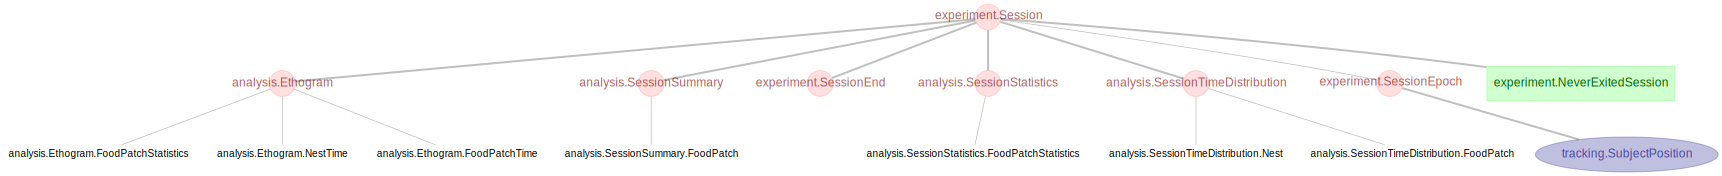

In [3]:
# View table diagram of `experiment.Session` + levels up/down
dj.Diagram(experiment.Session) + 2

# Example 1: Position Tracking

In [4]:
# Example: position tracking table restricted by a subject and some particular sessions
tracking.SubjectPosition & 'subject = "BAA-1099790"' & 'session_start BETWEEN "2021-06-04" AND "2021-06-10"'

experiment_name e.g exp0-a,subject,session_start,time_bin_start datetime of the start of this recorded TimeBin,epoch_start datetime of the start of this Epoch,timestamps (datetime) timestamps of the position data,"position_x (px) animal's x-position, in the arena's coordinate frame","position_y (px) animal's y-position, in the arena's coordinate frame","position_z (px) animal's z-position, in the arena's coordinate frame",area (px^2) animal's size detected in the camera,speed (px/s) speed
exp0.1-r0,BAA-1099790,2021-06-04 07:46:35.178000,2021-06-04 07:00:00,2021-06-04 07:46:35.178000,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
exp0.1-r0,BAA-1099790,2021-06-04 07:46:35.178000,2021-06-04 07:00:00,2021-06-04 07:56:35.178000,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
exp0.1-r0,BAA-1099790,2021-06-04 07:46:35.178000,2021-06-04 08:00:00,2021-06-04 08:00:00,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
exp0.1-r0,BAA-1099790,2021-06-04 07:46:35.178000,2021-06-04 08:00:00,2021-06-04 08:10:00,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
exp0.1-r0,BAA-1099790,2021-06-04 07:46:35.178000,2021-06-04 08:00:00,2021-06-04 08:20:00,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=


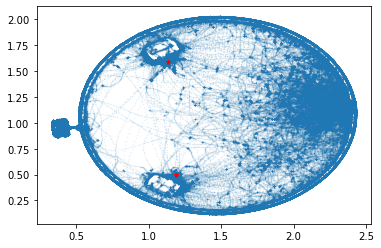

In [5]:
# Fetch positions from the table (array of arrays)
positionx, positiony = (
    tracking.SubjectPosition
    & 'subject = "BAA-1099790"'
    & 'session_start BETWEEN "2021-06-04" AND "2021-06-10"').fetch(
    'position_x', 'position_y', order_by='epoch_start') 
# Stack arrays to get single x, y arrays and do pixel -> meter conversion
positionx = np.hstack(positionx)
positiony = np.hstack(positiony)
positionx = positionx * 0.00192 
positiony = positiony * 0.00192
# Get location of patches from 'FoodPatch' table (which ingests from metadata)
patchx, patchy = (experiment.ExperimentFoodPatch.Position).fetch('food_patch_position_x', 'food_patch_position_y')
# Plot position data with food patch positions overlaid
fig, ax = plt.subplots(1,1)
ax.plot(positionx, positiony, '.', alpha=0.1, markersize=1)
for x, y in zip(patchx, patchy):
    ax.plot(x, y, 'r*', markersize=5)

# Example 2: Session Summary Analysis

In [6]:
# Example: session summary table restricted by sessions
analysis.SessionSummary & 'session_start >= "2021-06-14"'

experiment_name e.g exp0-a,subject,session_start,total_distance_travelled (m) total distance the animal travelled during this session,total_pellet_count total pellet delivered for all patches during this session,total_wheel_distance_travelled total wheel distance for all patches,change_in_weight weight change before/after the session
exp0.1-r0,BAA-1099790,2021-06-15 13:59:20.369000,1669.36,201,20151.1,4.8
exp0.1-r0,BAA-1099790,2021-06-16 13:21:37.711000,1453.87,106,10628.7,2.6
exp0.1-r0,BAA-1099790,2021-06-17 13:07:55.917000,1472.2,150,15082.9,3.7
exp0.1-r0,BAA-1099790,2021-06-25 13:22:59.812000,1267.98,250,28875.5,6.1
exp0.1-r0,BAA-1099790,2021-06-28 12:43:44.099000,2993.43,222,38537.8,5.4


In [7]:
# Aggregate over subjects and get mean values
subject_summary_query = experiment.Experiment.Subject.aggr(analysis.SessionSummary, 
                                   mean_distance='AVG(total_distance_travelled)', 
                                   mean_pellet='AVG(total_pellet_count)',
                                   mean_wheel_distance='AVG(total_wheel_distance_travelled)',
                                   mean_weight_change='AVG(change_in_weight)')
subject_summary_query

experiment_name e.g exp0-a,subject,mean_distance calculated attribute,mean_pellet calculated attribute,mean_wheel_distance calculated attribute,mean_weight_change calculated attribute
exp0.1-r0,BAA-1099790,1874.1334979717549,166.6154,19346.26502403846,5.503846237292657
exp0.1-r0,BAA-1099791,1850.0412190755208,150.0000,16310.257866753473,2.9555555714501276
exp0.1-r0,BAA-1099793,2361.7435607910156,152.5000,16269.679248046876,3.2600000143051147
exp0.1-r0,BAA-1099794,1535.6339768629807,170.0769,17836.713416466348,4.569230758226835
exp0.1-r0,BAA-1099795,2084.028638203939,125.2222,13313.77647210492,2.522222214274936


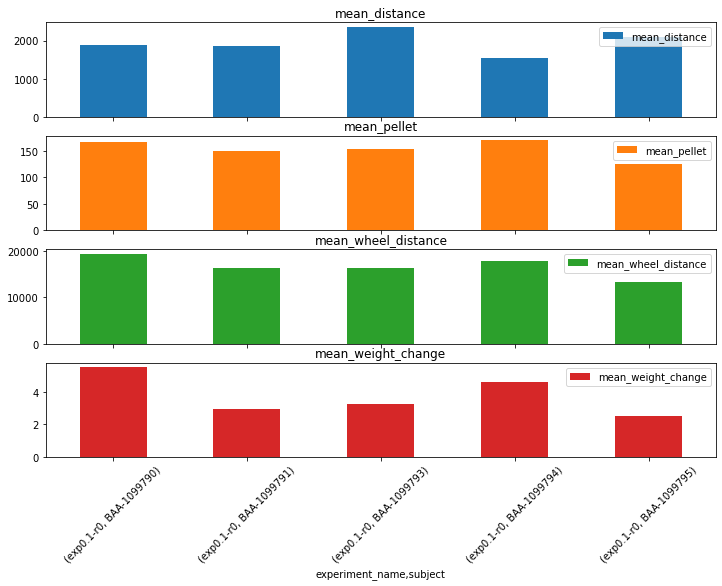

In [8]:
# Fetch data back in the form of pandas DataFrame
subject_summary = subject_summary_query.fetch(format='frame')
# Ensure all data is in float representation
subject_summary = subject_summary.astype({'mean_distance': float, 'mean_pellet': float, 
                        'mean_wheel_distance': float, 'mean_weight_change': float,})
# Create bar plots
subject_summary.plot.bar(subplots=True, figsize=(12, 8), rot=45);